# Create an ESN for sepsis shared features (trial 1)

## Load ICU sepsis data log

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as m
%matplotlib inline
path = '../training/'

In [2]:
# Choose patient sample
sample_num = 785

In [3]:
# Import and print dataframe layout
def loadICUdata(sample_num, path = './', printdf = False):
    samplestr = 'p' + (str(sample_num) + '.psv').rjust(9, '0')
    fname = path + samplestr
    df = pd.read_csv(fname, sep = '|')
    #print(fname, ' file:')
    if printdf:
        print(df)
    return df

df = loadICUdata(sample_num, path, False)
#df

## Check sepsis labels for ALL patients

In [4]:
# get the sepsis label value
def get_sepsislabel(df):
    sl = df[["SepsisLabel"]]
    count = df['SepsisLabel'].value_counts()
    count_healthy = -1
    count_sep = -1
    
    if len(count) == 2:
        count_sep = count[1]
        count_healthy = count[0]
        
    elif len(count) == 1:
        if sl.values[0] == 0:
            count_healthy = count.values[0]
        elif sl.values[0] == 1:
            count_sep = count.values[0]
    return sl, count_healthy, count_sep


In [5]:
count = df['SepsisLabel'].value_counts()
count.values
len(count)
sl, ch, cs = get_sepsislabel(df)
len(sl)

260

In [6]:
# Print result
sl, ch, cs = get_sepsislabel(df) 
print('patient {:d}, {:d} {:d} {:2.2f}%'.format(sample_num, ch, cs, 100*cs/len(sl)))

patient 785, 260 -1 -0.38%


## Loop study, sepsis presence

In [7]:
# Run in a loop and get a sepsis presence report
SL = []    #Sepsis labels
CH = []    #Healthy hours count
CS = []    #Sepsis hours count
CSCH = []  #Percentage cs/(cs+ch)
DATA = []  #DATA structure
for i in range(1,5001):
    df = loadICUdata(i, path, False)
    DATA.append(df) 
    sl, ch, cs = get_sepsislabel(df) 
    SL.append(sl)
    CH.append(ch)
    CS.append(cs)
    if cs != -1 and ch != -1:
        csch = 1.0*cs/(cs + ch)
    elif cs == -1:
        csch = 0
    elif ch == -1:
        csch = 1
    CSCH.append(csch)
    
CSCH = np.array(CSCH)

In [8]:
# Count sepsis patients
print(CSCH, np.count_nonzero(CSCH))

[0. 0. 0. ... 0. 0. 0.] 279


In [9]:
sepsis_idx = np.where(CSCH!=0)

In [10]:
# Check percentage of sepsis hours for sepsis patients
CSCH[sepsis_idx]

array([0.11111111, 0.02214022, 0.27777778, 0.11363636, 1.        ,
       0.09615385, 0.28571429, 0.33333333, 0.25641026, 0.14754098,
       1.        , 0.2195122 , 1.        , 0.07627119, 0.04975124,
       0.15151515, 0.09183673, 0.37037037, 0.20408163, 0.06944444,
       0.04587156, 0.625     , 0.07894737, 0.09183673, 0.24390244,
       1.        , 0.03846154, 0.2       , 0.10465116, 0.76923077,
       0.76923077, 0.27777778, 0.225     , 0.17857143, 1.        ,
       0.08256881, 0.20408163, 0.16981132, 0.14084507, 0.81818182,
       0.0990099 , 0.43478261, 0.12820513, 0.09803922, 0.33333333,
       0.13461538, 0.41666667, 1.        , 0.11627907, 0.08333333,
       0.23255814, 0.66666667, 0.29411765, 1.        , 0.90909091,
       0.38461538, 0.03125   , 0.07246377, 0.04291845, 0.20833333,
       1.        , 0.16393443, 0.90909091, 0.22727273, 1.        ,
       0.33333333, 0.13888889, 0.4       , 0.35714286, 0.25641026,
       0.17307692, 0.15384615, 0.4       , 0.625     , 1.     

## Matrix Sepsis

In [11]:
def get_dfmaxcount(list_of_lists):
    maxval = -1
    maxval_i = -1
    for i in range(len(list_of_lists)):
        val = list_of_lists[i].count(axis = 0)[0]
        if val > maxval:
            maxval = val
            maxval_i = i
    return maxval, maxval_i

In [12]:
# get max val in SepsisLabel count and idx position
mv, mvi = get_dfmaxcount(SL)

In [13]:
mv, mvi

(336, 1921)

In [14]:
# Initialize sepsis matrix
sepsis_matrix = -1 * np.ones((len(SL),mv), dtype=int)
for i in range(len(SL)):
    sepsis_matrix[i][0:(SL[i].count(axis = 0)[0])] = (SL[i].values).flatten()
np.shape(sepsis_matrix)

(5000, 336)

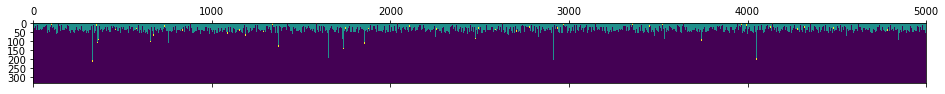

In [15]:
plt.matshow(np.transpose(sepsis_matrix))

## Sepsis keys for the ESN

In [16]:
sepsis_idx = np.where(CSCH!=0)
healthy_idx = np.where(CSCH==0) 

In [17]:
# We use features (9) shared by all sepsis patients
s_keys = {}
s_keys = ['HospAdmTime']#,'HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'ICULOS'] #, 'SepsisLabel']
#s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'ICULOS']#'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
# s_keys = ['Age', 'Gender', 'SepsisLabel']
# s_keys = ['SepsisLabel']
type(s_keys)
len(s_keys)

1

In [18]:
DATA[0]["HR"].values

array([  nan,  93. ,  91. ,  93. ,  93. ,   nan,  91.5,  94. ,  94. ,
       102. , 106. , 107. , 102. ,  98. ,  95. , 105. ,  94. ,  98. ,
        98. , 105. ,  96. , 102. , 105. , 107. ])

In [19]:
# Feature matrix (removing nan)
feature_matrix = []
patient = []
sepsis_label = []
for i in range(5000):
    initval = 0
    A = initval * np.ones((DATA[i].shape[0],len(s_keys)), dtype=np.double)
    j = 0
    for key in s_keys:
        A[:,j] = DATA[i][key].values
        j = j + 1
       # print (i, key, j)
    A = np.nan_to_num(A)
    sep_lab = (DATA[i]["SepsisLabel"].values).reshape(-1,1)
    if i==0:
        feature_matrix=(A)
        patient = i*np.ones((DATA[i].shape[0],1),dtype=np.int)
        sepsis_label = sep_lab
        
    else: 
        feature_matrix = np.vstack((feature_matrix, A))
        patient = np.vstack((patient, i*np.ones((DATA[i].shape[0],1),dtype=np.int)))
        sepsis_label = np.vstack((sepsis_label, sep_lab))

In [20]:
type(feature_matrix[0])

numpy.ndarray

In [21]:
feature_matrix
np.shape(feature_matrix)

(188453, 1)

In [22]:
# Keep a raw copy
raw_feature_matrix = np.copy(feature_matrix)

In [23]:
patient
np.shape(patient)

(188453, 1)

In [24]:
sepsis_label
np.shape(sepsis_label)

(188453, 1)

In [25]:
# Single entry example
i_e = 90000
print(patient[i_e])
print(feature_matrix[i_e,:])
print(sepsis_label[i_e])


[2378]
[-1.38]
[0]


37 entries x 1


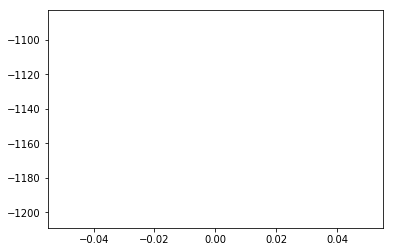

In [26]:
i_pat = 6

def plot_patient_features(n_pat, features, patient_array):
    plot_j = np.where(patient == n_pat)[0]
    for j in range (len(plot_j)):
        plt.plot(features[plot_j[j],:])    
    print(len(plot_j), "entries x", np.shape(features)[1])
    return

def print_patient_features(n_pat, features, patient_array):
    print("Patient", n_pat)
    print_j = np.where(patient == n_pat)[0]
    for j in range (len(print_j)):
        print(features[print_j[j],:])    
    return

plot_patient_features(i_pat, feature_matrix, patient)

## Preprocess features (log(-HospAdmTime-1))

In [27]:
feature_matrix= np.copy(raw_feature_matrix)
feat_i = s_keys.index('HospAdmTime')

In [28]:
print(np.min(raw_feature_matrix[:,feat_i]), np.max(raw_feature_matrix[:,feat_i]))
argmin = (np.argmin(raw_feature_matrix[:,feat_i]))
print(argmin, patient[argmin])

# for i in range(len(raw_feature_matrix[:,feat_i])):
#     print(raw_feature_matrix[i,feat_i])

-5366.86 0.0
30281 [784]


HospAdmTime
-5366.86 0.0


0

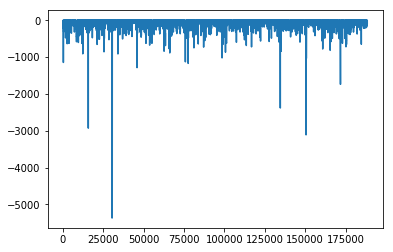

In [32]:
print (s_keys[feat_i])
print (np.min(feature_matrix[:,feat_i]),np.max(feature_matrix[:,feat_i]))
plt.plot(feature_matrix[:,feat_i])
feat_i

In [33]:
change_i = np.where(raw_feature_matrix[:,feat_i]!=np.nan)[0]
print(len(change_i))
change_i

188453


array([     0,      1,      2, ..., 188450, 188451, 188452], dtype=int64)

In [34]:
change_feature = True
if change_feature:
    feature_matrix[change_i,feat_i] = np.log(1-np.copy(raw_feature_matrix[change_i,feat_i]))
    # for i in range(len(change_i)):
    for i in range(50):
        print(raw_feature_matrix[change_i[i],feat_i],feature_matrix[change_i[i],feat_i])

-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.82

0.0 8.588184597834516


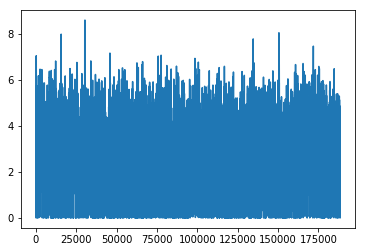

In [35]:
print(np.min(feature_matrix[:,feat_i]), np.max(feature_matrix[:,feat_i]))
plt.plot(feature_matrix[change_i,feat_i])

In [36]:
print(np.min(feature_matrix), np.max(feature_matrix[:,:19]))

0.0 8.588184597834516


In [37]:
np.shape(feature_matrix[:,:5])

(188453, 1)

## Mapminmax normalise scale per feature per patient

In [38]:
norm_feat_pat = False
if norm_feat_pat:
    for i in range(5000):
        i_pat = np.where(patient==i)[0]
        scaler = MinMaxScaler()
        scaler.fit(feature_matrix[i_pat,:5])
        feature_matrix[i_pat,:5] = scaler.transform(feature_matrix[i_pat,:5])
        
# Per single feature
#         for j in range(np.shape(feature_matrix)[1]):
#             scaler.fit(feature_matrix[i_pat,j])
#             feature_matrix[i_pat,j] = scaler.transform(feature_matrix[i_pat,j])

## Divide in 2 sets

In [39]:
# Choose percentage (50%, 90/10%, ...)
# A_B_limit = int(5000*0.5)
A_B_limit = int(5000*0.9)
A_idx = np.where(patient < A_B_limit)[0]
features_A = feature_matrix[A_idx,:]
np.shape(features_A)

(169634, 1)

In [40]:
B_idx = np.where(patient >= A_B_limit)[0]
features_B = feature_matrix[B_idx,:]
np.shape(features_B)

(18819, 1)

In [41]:
print(np.min(features_A), np.max(features_A))
print(np.min(features_B), np.max(features_B))
print("\n======  \nA feature ranges")
for i in range (np.shape(features_A)[1]):
    print(s_keys[i], np.min(features_A[:,i]), np.max(features_A[:,i]))

0.0 8.588184597834516
0.0 7.462163244003497

A feature ranges
HospAdmTime 0.0 8.588184597834516


## Create an ESN

#### Create rand masks (input weight)
#### M⊂[-1,1]
#### Mb⊂[-1,1]

In [42]:
# ESN Paramenters
N = 200      # Neurons
mem = 0.1    # memory
scale = 0.2  # scaling factor

In [43]:
# Nonlinear mapping function
def sigmoid(x, exponent):
    return 1/(1+np.exp(-exponent*x))-0.5

def rectify(x, slope):
    return slope*np.asarray(x>0, dtype=np.double)*x

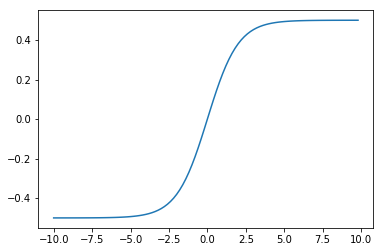

In [44]:
sigmoid_exponent = 1
rect_slope = 1
func = sigmoid
a = np.linspace(-10, 10, 100, False)
b = func(a,sigmoid_exponent)
plt.plot(a,b)

In [45]:
# Mask parameters
M = 2*np.random.rand(np.shape(features_A)[1],N)-1
Mb = 2*np.random.rand(1,N)-1
print(np.shape(M))
print(np.shape(Mb))
print(np.min(M), np.max(M))
print(np.min(Mb), np.max(Mb))


(1, 200)
(1, 200)
-0.9976210953082125 0.9664614304173116
-0.9955782623288325 0.9975888904779255


In [46]:
# Train set features
print(np.min(features_A), np.max(features_A))

0.0 8.588184597834516


In [47]:
# Create ESN
ESN = np.ones((np.shape(features_A)[0],N), dtype=np.double)
IN = np.matmul(features_A, M) + np.repeat(Mb, np.shape(features_A)[0], axis=0)
print(np.shape(IN))
print(np.min(IN), np.max(IN))
p = np.zeros((1,N),dtype=np.double)
for i in range(np.shape(features_A)[0]):
    i
    in_val = scale*IN[i,:]+p*mem
    ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
    p = np.copy(np.roll(ESN[i,:],1))

(169634, 200)
-9.21588319862938 8.483128714112624


In [48]:
# Create ESN 
def feedESN(features, mask, mask_bias, scale, mem):
    ESN = np.ones((np.shape(features)[0],N), dtype=np.double)
    IN = np.matmul(features, M) + np.repeat(Mb, np.shape(features)[0], axis=0)
    print(np.shape(IN))
    print(np.min(IN), np.max(IN))
    p = np.zeros((1,N),dtype=np.double)
    for i in range(np.shape(features)[0]):
        i
        in_val = scale*IN[i,:]+p*mem
        ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
        p = np.copy(np.roll(ESN[i,:],1))
    return ESN

In [49]:
ESN = feedESN(features_A, M, Mb, scale, mem)

(169634, 200)
-9.21588319862938 8.483128714112624


(169634, 200)
-0.364807186501771 0.348057517827735


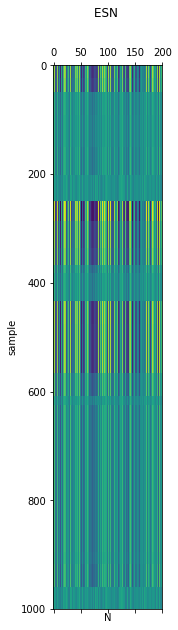

In [50]:
fig, ax = plt.subplots(figsize=(13,10))
ax.matshow((ESN[:1000,:]))
ax.set_title("ESN \n",loc='center')
ax.set_xlabel('N')
ax.set_ylabel('sample')
print(np.shape(ESN))
print(np.min(ESN), np.max(ESN))

### Training

In [51]:
ESNinv = np.linalg.pinv(ESN)
print(np.shape(ESNinv))

(200, 169634)


In [52]:
ytrain = sepsis_label[A_idx]

In [53]:
w = np.matmul(ESNinv, ytrain)


In [54]:
print(type(ESNinv))
print(type(ytrain))
print(np.shape(ytrain.reshape(-1,1)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(169634, 1)


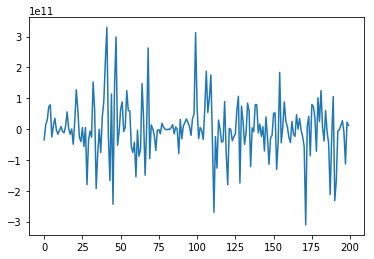

In [55]:
plt.plot(w)

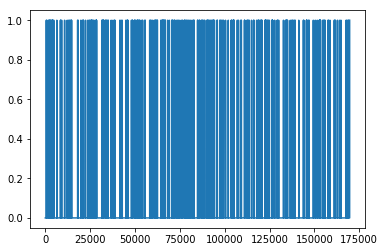

In [56]:
plt.plot(ytrain)

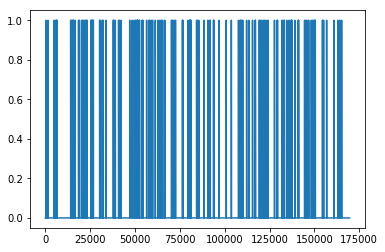

In [57]:
class_threshold = 0.08
Y_pred = np.asarray(np.matmul(ESN,w)>class_threshold,dtype=np.double)
plt.plot(Y_pred)

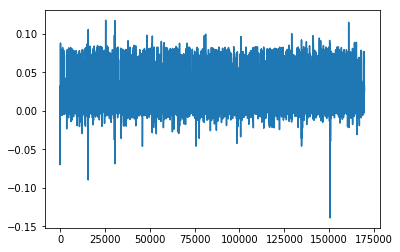

In [58]:
plt.plot(np.matmul(ESN,w))

In [59]:
#Creating the confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(ytrain, Y_pred)
print(cm[0,0],cm[0,1])
print(cm[1,0],cm[1,1])
print(accuracy_score(ytrain, Y_pred))

167108 161
2347 18
0.9852152280792765


### Testing

In [60]:
ESNtest = feedESN(features_B, M, Mb, scale, mem)

(18819, 200)
-8.138095595459916 7.421407172311822


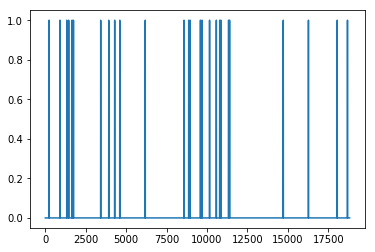

In [61]:
ytest = sepsis_label[B_idx]
plt.plot(ytest)

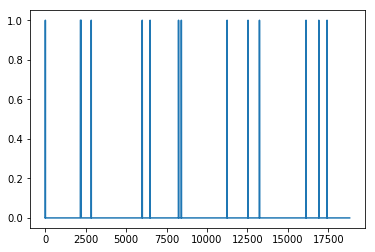

In [62]:
Y_pred = np.asarray(np.matmul(ESNtest,w)>class_threshold,dtype=np.double)
plt.plot(Y_pred)

In [71]:
#Creating the confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
cm = confusion_matrix(ytest, Y_pred)
print(cm[0,0],cm[0,1])
print(cm[1,0],cm[1,1])
print(accuracy_score(ytest, Y_pred))

18491 70
258 0
0.9825708061002179


In [70]:
np.sum(sepsis_label[B_idx])

258

In [68]:
np.sum(ytest)

258

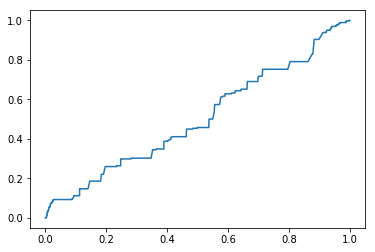

In [79]:
fpr, tpr, thresholds = roc_curve(ytest, np.asarray(np.matmul(ESNtest,w)))
plt.plot(fpr,tpr)


In [80]:
thresholds

array([ 1.02341370e+03,  1.02241370e+03,  9.90066528e-02, ...,
       -1.98326111e-02, -2.18276978e-02, -1.21278004e+06])

In [82]:
auc = roc_auc_score(ytest, np.asarray(np.matmul(ESNtest,w)))
auc

0.5006570624661445

In [64]:
# # Blind random permutation comparison
# Y_pred_rand = Y_pred[np.random.permutation(len(ytest))]
# cm = confusion_matrix(ytest, Y_pred_rand)
# print(cm[0,0],cm[0,1])
# print(cm[1,0],cm[1,1])
# print(accuracy_score(ytest, Y_pred_rand))

### Report

In [65]:
# Report config
if norm_feat_pat:
    print ("norm")
    print(scaler)
else: 
    print("not norm")
print("func: ", func)
print("func_argument: ", sigmoid_exponent, rect_slope)
print("mem: ", mem)
print("scale: ", scale)
print("threshold: ", class_threshold)
print("s_keys: ", s_keys)


not norm
func:  <function sigmoid at 0x000002550BB4CAE8>
func_argument:  1 1
mem:  0.1
scale:  0.2
threshold:  0.08
s_keys:  ['HospAdmTime']
